# Section 10

In [125]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

# Motivating data set, Mauna Loa CO2

- Longest running continuous collection of atmospheric CO2 measurements
- Measurements aggregated to monthly level
- Seasonal pattern

In [137]:
data = pd.read_csv("https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv", header=51)

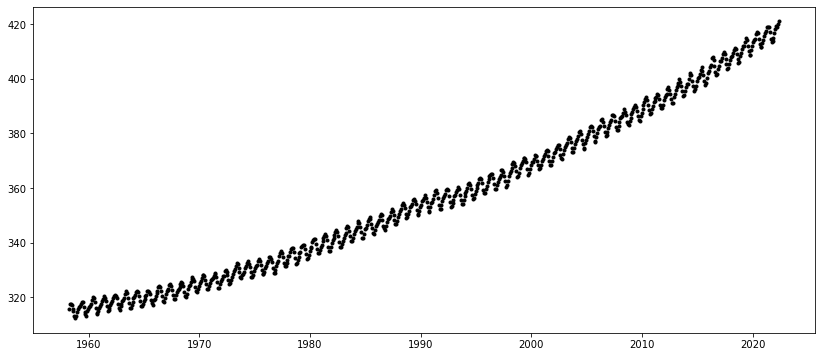

In [189]:
plt.figure(figsize=(14,6))
plt.plot(data["decimal date"], data["average"], "k.");

- Data has an annual cycle, peaks in the spring, lowest in the fall

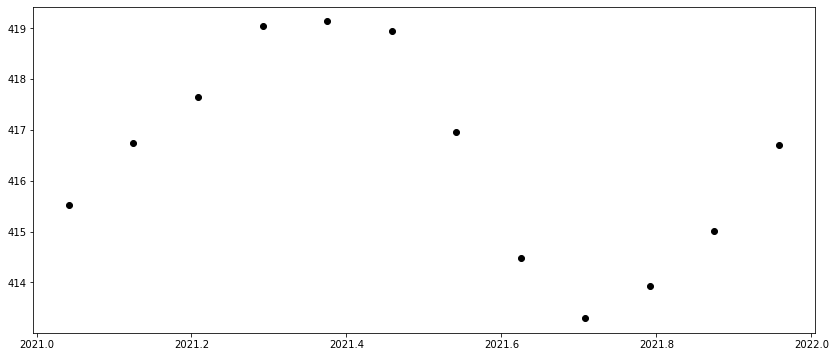

In [190]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"], "ko");

# How do we fit this function?

- You need to write down some kind of mathematical formula that describes this process, difficult!  There's a seasonal pattern, and an overall "linear" looking increase, and perhaps a quadratic looking acceleration. 

- Let's start simple, and try and increase complexity.  Sometimes it's hard to resist the temptation to reach for the most "advanced" approach you know first.  It's always better to work up in this direction than the opposite.  

- **Mathematical functions are the main tools we use to fit data.  Whether we are extrapolating or forecasting, or interpolating, we need something that given an `x`, outputs a `y`, or the range of plausible `y` values.  We'll first try using familiar functions you've seen before, then we'll use our intuition to work our way up to building a Gaussian process, which are a fundamentally different way of representing functions.**

# Guesses for our line:

First lets try fitting the whole thing with a straight line.  Let's ignore the annual up-and-down pattern (the technical term is called "seasonality", link to description of term)  The equation for a straight ine is $y = m x + b$.  What should we guess for $m$ and $b$?

- $\beta_0$ is the Y intercept, so what's the CO2 value here at year = 0?  Kind of hard.  It's usually good to normalize our data, so lets
rescale things so that the data starts near year "zero".  We can do this by subtracting the smallest x date from all our x values. Doing so won't change the results of our model, so long as we make sure to add it back in later.  

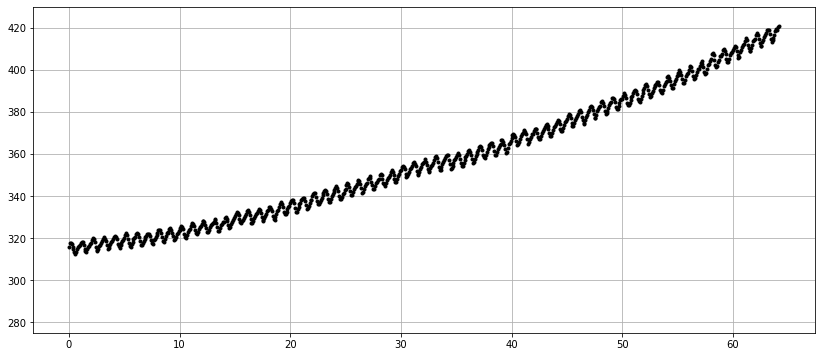

In [188]:
plt.figure(figsize=(14,6))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");

plt.grid(True);
plt.ylim([275, 430]);

Because of the slight curve (which we are supposedly trying to ignore!) it's a bit tricky to pick where the line should hit zero.  The first datapoint hits zero at:

In [181]:
data.sort_values(["decimal date"])["average"].head(1)

0    315.7
Name: average, dtype: float64

so we might as well use that as one of our guesses.  Eyeballing it with upward curve makes this a bit tricky, but lets also try 300, and 290.   

The slope parameter `m` might be a little easier.  Slope is defined as "rise over run", so lets try calculating that at a few spots.  

- Lets start from year 10 to year 30:  Looking at the chart, at year 10, CO2 is about 320.  At year 30 CO2 is about 350.  That gives $\frac{350 - 320}{30-10} = 1.5$. - Year 30 to year 60: $\frac{410 - 350}{60-30} = 2.0$
- Year 40 to year 50: $\frac{385 - 370}{50-40} = 2.0$

Now lets plug in our guesses and plot a few lines.

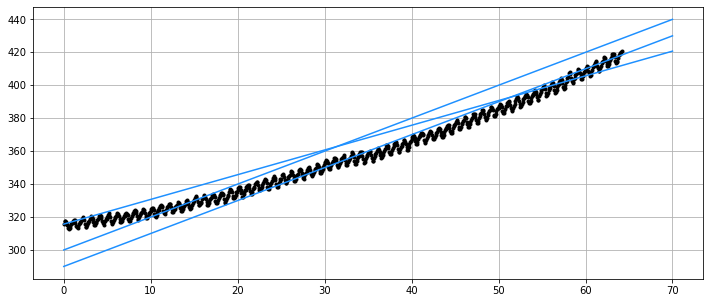

In [191]:
xl = np.linspace(0, 70, 200)

line1 = 315.7 + 1.5 * xl
line2 = 300.0 + 2.0 * xl
line3 = 290.0 + 2.0 * xl

plt.figure(figsize=(12,5))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");
plt.plot(xl, line1, "dodgerblue")
plt.plot(xl, line2, "dodgerblue")
plt.plot(xl, line3, "dodgerblue")

plt.grid(True);

These are clearly pretty rudimentary guesses, but they at least look plausible?

Lets also fit the model in PyMC.  We can see that with a Bayesian approach, we can let the model produce guesses, and associate each guess with a "plausability score", or a posterior probablity. 

### Fit the model in pymc, compare to our guess

In [192]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu = pm.Deterministic("mu", m * x_ + b)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])
    
    
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8794, but should be close to 0.8. Try to increase the number of tuning steps.


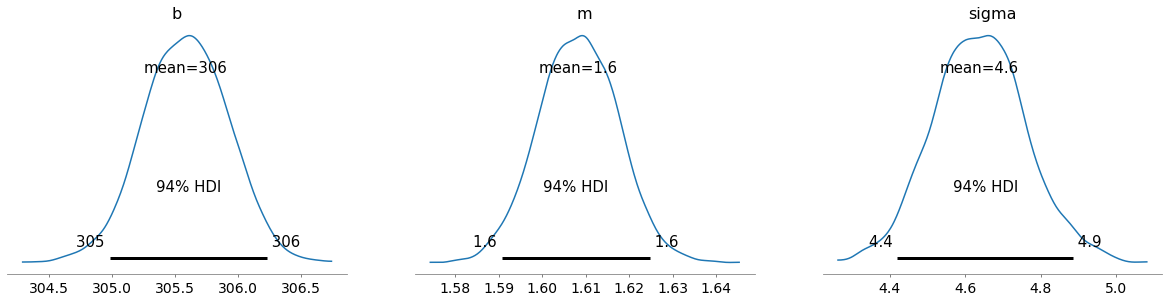

In [193]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "sigma"]);

In [194]:
with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

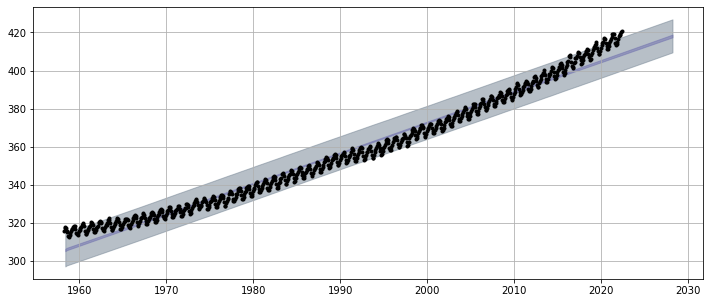

In [198]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");

plt.grid(True);

- Our guesses were pretty good, but PyMC's guesses are better
- Blue shaded is posterior predictive estimate of the line.  Since we have so much data, PyMC is pretty confident about this.
- Gray shaded is posterior predictive estimate of the data generated by the line.  It's wide enough to cover most of the data.

# Section 20: Periodic function

Lets see if we can improve our forecast by including a term for the periodic up and down.  Lets try a Cosine or sine function.  Remember that both are the same, except one is phase shifted from the other, so it doesn't really matter which we choose.  After some fiddling with the function, here is what I could come up with. 

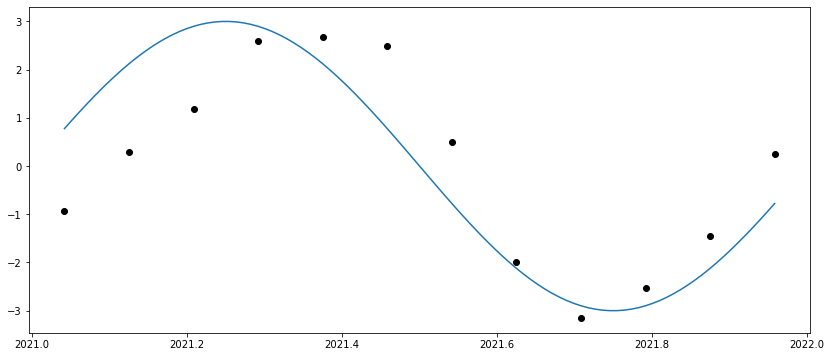

In [229]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko");

xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 100)
plt.plot(xl, 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi))

Not great, there's certainly room for improvement.  This does give us some OK starting points though, and we can use these to help us set priors for our PyMC model.

- frequency: 1 (cycle per year)
- amplitude: 3.  After normalizing the observed data by subtracting the mean, we can see the cycle goes up and down from about -3 to 3. 
- phase: $-\frac{\pi}{2}$, this gets cosine to start at zero and increase first, which sort of matches the data, but should be a free parameter in the model.

In [283]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu_linear = pm.Deterministic("mu_linear", m * x_ + b)
    
    
    A = pm.HalfNormal("A", sigma=5)
    phi = pm.Normal("phi", mu=-np.pi / 2, sigma=0.1)
    freq = pm.Normal("freq", mu=1.0, sigma=0.1)
    mu_periodic = pm.Deterministic("mu_periodic", A * pm.math.cos(2 * np.pi * x_ * freq + phi))
    
    mu = pm.Deterministic("mu", mu_linear + mu_periodic)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])
    
    
with model:
    idata = pm.sample(tune=2000, chains=2, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m, sigma, A, phi, freq]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 35 seconds.


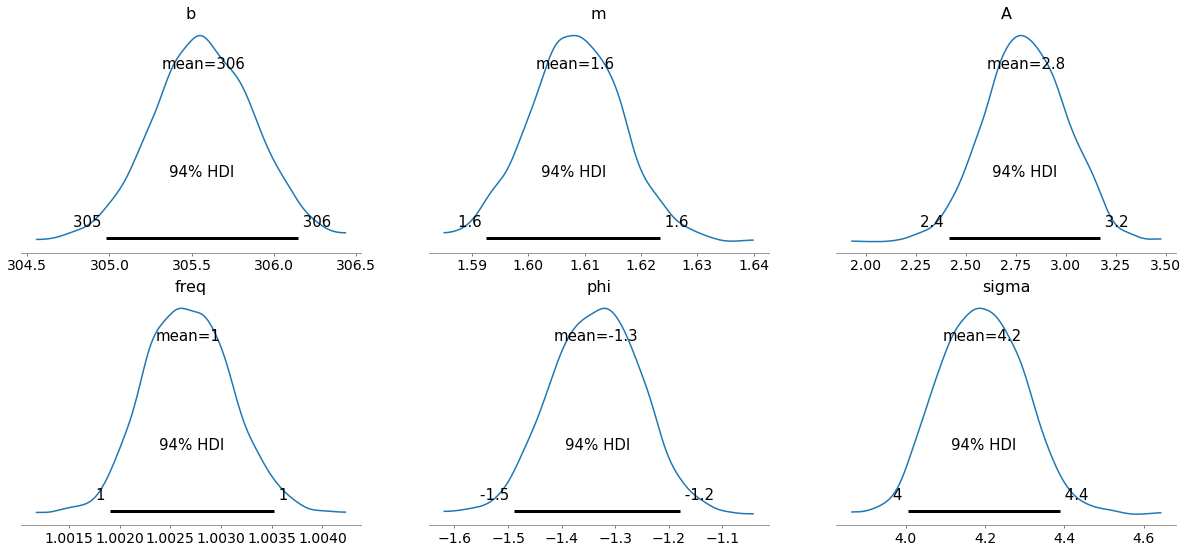

In [284]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "A", "freq", "phi", "sigma"]);

- It was a bit tricky to get the sampler to converge, but now it looks like the results are sensible.  The parameter estimates are also somewhat in line with our guesses.  
- Now lets look at the posterior predictive and draw some samples

In [285]:
xl = np.linspace(0, 70, 1000)

with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

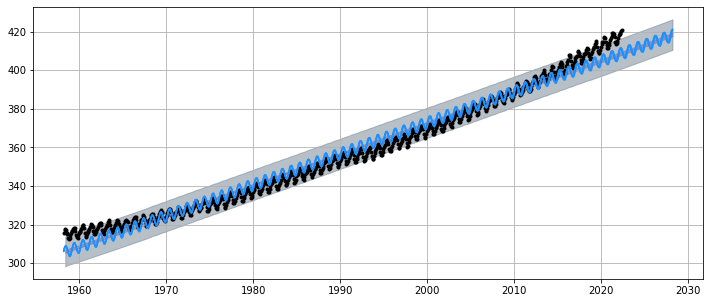

In [286]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

plt.plot(data["decimal date"], data["average"], "k.");
plt.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue');

plt.grid(True);

- the results look similar to the straight line model, except when we look at individual samples of `mu` we can see the seasonal pattern reflected. 
- Lets zoom in also and look at the small scale structure

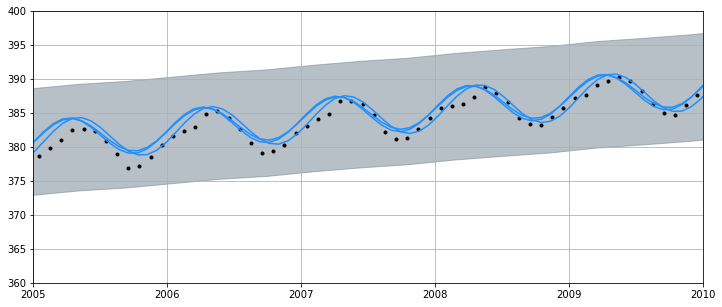

In [293]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

plt.plot(data["decimal date"], data["average"], "k.");
plt.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue');

plt.grid(True);
plt.xlim([2005, 2010]);
plt.ylim([360, 400]);

- Even at the best looking part of the curve, there are still pretty obvious issues still here.

What is wrong:
- Linear term seems insufficient.  Upward increasing trend
- "Cosine" seems insufficient.  Is it a perfect sine wave?  Or is something that's almost a sine wave, but still has a repeating pattern.
- With this functional approach, nothing stops us from forecasting infinitely far into the future.  Is that reasonable?
- How much more fine structure are we missing in the data?

Continuing with this approach, what might we try?  Coming up with functional forms is difficult!  Also, how much do we care about these parameters?

# Section 30

Let's take a different approach, lets try drawing, and lets think carefully about *how* we are drawing.  To start, lets focus on the most recent years worth of data.

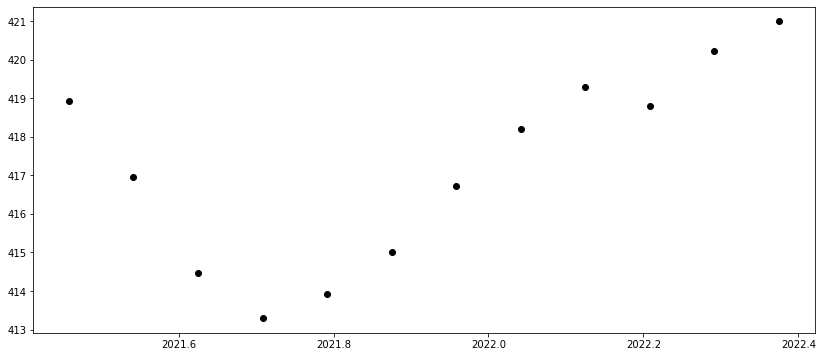

In [298]:
year = data.sort_values("decimal date").tail(12)

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"], "ko");

- Connect the dots?   No, we shouldn't expect to predict CO2 at every point.  The process by which CO2 gets into the atmosphere is too complicated.
- Lets start by drawing somewhere in the middle.  